In [1]:
!pip install -U segmentation-models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install gradio

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
import os
import cv2
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

In [6]:
from keras import backend as K
from keras.models import load_model

In [7]:
import gradio as gr

In [8]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [9]:
weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [10]:
satellite_model = load_model('/content/semantic_segmentation_irregularity_and_regularity_building.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [11]:
satellite_model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'clas

In [12]:
from keras.models import load_model

In [13]:
image = Image.open('/content/Predicted_2.png').convert('RGB') # Convert the image to RGB
image = image.resize((128,128))
image = np.array(image)
image = np.expand_dims(image, 0)

In [14]:
prediction = satellite_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


In [15]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [16]:
type(predicted_image)

numpy.ndarray

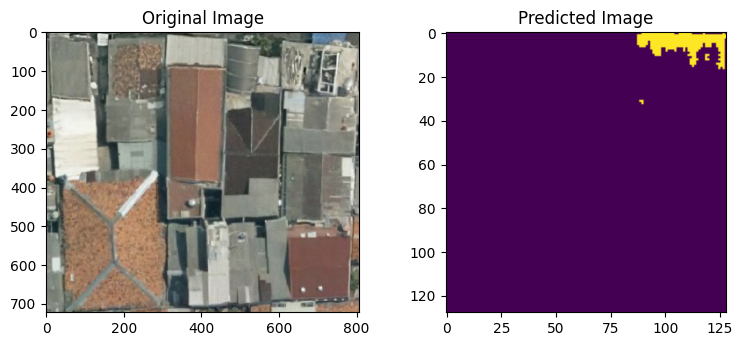

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/Predicted_2.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [18]:
def process_input_image(image_source):
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  return 'Predicted Masked Image', predicted_image

In [48]:
import numpy as np
from PIL import Image

def process_input_image(image):
    # Konversi dari NumPy array ke PIL Image jika perlu
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype(np.uint8))

    # Resize gambar ke (128, 128)
    image_resized = image.resize((128, 128))
    image_array = np.array(image_resized)  # Konversi ke NumPy array
    image_array = np.expand_dims(image_array, axis=0)  # Tambahkan batch dimensi

    # Prediksi dengan model
    prediction = satellite_model.predict(image_array)
    print("Prediction shape:", prediction.shape)  # Debugging

    # Pastikan format output sesuai (H, W, C)
    if prediction.ndim == 4:  # (1, H, W, C)
        prediction = np.squeeze(prediction, axis=0)
    elif prediction.ndim == 2:  # (H, W) -> Tambahkan channel
        prediction = np.expand_dims(prediction, axis=-1)

    # Normalisasi output ke skala 0-255
    prediction = cv2.normalize(prediction, None, 0, 255, cv2.NORM_MINMAX)
    prediction = prediction.astype(np.uint8)

    # Terapkan colormap untuk hasil yang lebih jelas
    if prediction.ndim == 2 or prediction.shape[-1] == 1:
        prediction = np.squeeze(prediction, axis=-1)
        prediction = cv2.applyColorMap(prediction, cv2.COLORMAP_JET)
        prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)

# Resize output hasil segmentasi agar lebih besar (512x512)
    prediction = cv2.resize(prediction, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Konversi ke format gambar PIL
    predicted_image = Image.fromarray(prediction)

    # Hitung jumlah pixel per kelas
    predicted_array = np.array(predicted_image)
    class_counts = np.bincount(predicted_array.flatten(), minlength=2)

    # Tentukan label kelas
    if class_counts[0] > 0 and class_counts[1] > 0:
        if class_counts[0] > class_counts[1]:
            class_label = "Teratur"
        else:
            class_label = "Tidak Teratur"
    elif class_counts[0] > 0:
        class_label = "Teratur"
    else:
        class_label = "Tidak Teratur"

    return f"Prediction Done: {class_label}", predicted_image


In [49]:
my_app = gr.Blocks()

In [51]:
with my_app:
  gr.Markdown("Satellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            # Remove the 'shape' argument and handle resizing within the processing function.
            img_source = gr.Image(label="Please select source Image")
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output",  interactive=True)
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [ ]:
my_app.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://90534e09454e067f37.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction shape: (1, 128, 128, 2)


In [23]:
my_app.close()

Closing server running on port: 7860
